In [1]:
# import tensorflow as tf
# tf.enable_eager_execution()

%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import mbspbs10pc.model as mbs_model
from mbspbs10pc import read_activations, utils
reload(read_activations)
reload(utils);

root = 'dl'

Using TensorFlow backend.


# Load raw data

In [2]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timestamp_seq, _ = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timestamp_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False)

In [3]:
tr_set[0][0].shape

(6341, 250)

# Init embedding matrix

In [4]:
D = 50
embedding = pd.read_csv('../../tmp/embedding.{}d.csv'.format(D), header=0, index_col=0)
embedding_matrix = embedding.values
embedding_matrix.shape

(2774, 50)

# Model

In [26]:
from keras.layers import CuDNNLSTM
reload(mbs_model);

model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=2774,
                              embedding_size=50,
                              recurrent_units=32,
                              dense_units=32,
                              attention_units=128,
                              bidirectional=True,
                              LSTMLayer=CuDNNLSTM)

('hx: ', TensorShape([Dimension(None), Dimension(250), Dimension(64)]))
('tx: ', TensorShape([Dimension(None), Dimension(250), Dimension(64)]))
('gamma: ', TensorShape([Dimension(None), Dimension(250), Dimension(128)]))
('beta: ', TensorShape([Dimension(None), Dimension(250), Dimension(128)]))
('delta: ', TensorShape([Dimension(None), Dimension(250), Dimension(128)]))
('alpha: ', TensorShape([Dimension(None), Dimension(250), Dimension(64)]))


In [27]:
from keras import optimizers as opt
model.compile(optimizer=opt.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['acc'])

In [28]:
# model.get_layer('mbs_embedding').set_weights([embedding_matrix])
# model.get_layer('mbs_embedding').trainable = True

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mbs_input (InputLayer)          (None, 250)          0                                            
__________________________________________________________________________________________________
mbs_embedding (Embedding)       (None, 250, 50)      138700      mbs_input[0][0]                  
__________________________________________________________________________________________________
timestamp_input (InputLayer)    (None, 250, 1)       0                                            
__________________________________________________________________________________________________
mbs_lstm (Bidirectional)        (None, 250, 64)      21504       mbs_embedding[0][0]              
__________________________________________________________________________________________________
timestamp_

In [30]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [31]:
# from keras.utils import plot_model

# plot_model(model, show_shapes=True, to_file='model_dot.png')

In [32]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1),
             EarlyStopping(monitor='val_loss', patience=15)] 

h = model.fit(tr_set[0], tr_set[1],
              epochs=100,
              callbacks=callbacks,
              batch_size=128,
              validation_data=(v_set))

Train on 6341 samples, validate on 705 samples
Epoch 1/100
6341/6341 [==============================] - 15s 2ms/step - loss: 0.7410 - acc: 0.5302 - val_loss: 0.6609 - val_acc: 0.6894
Epoch 2/100
6341/6341 [==============================] - 8s 1ms/step - loss: 0.6482 - acc: 0.6797 - val_loss: 0.6317 - val_acc: 0.7376
Epoch 3/100
6341/6341 [==============================] - 8s 1ms/step - loss: 0.6045 - acc: 0.7340 - val_loss: 0.5789 - val_acc: 0.7177
Epoch 4/100
6341/6341 [==============================] - 9s 1ms/step - loss: 0.5764 - acc: 0.7519 - val_loss: 0.6216 - val_acc: 0.6936
Epoch 5/100
6341/6341 [==============================] - 8s 1ms/step - loss: 0.5561 - acc: 0.7727 - val_loss: 0.5464 - val_acc: 0.7787
Epoch 6/100
6341/6341 [==============================] - 8s 1ms/step - loss: 0.5302 - acc: 0.7923 - val_loss: 0.5438 - val_acc: 0.7858
Epoch 7/100
6341/6341 [==============================] - 8s 1ms/step - loss: 0.5094 - acc: 0.8093 - val_loss: 0.5741 - val_acc: 0.7716
Epoch 8

In [34]:
# h.history['loss']

In [35]:
# from keras.callbacks import History

# history = History()
# history.history = {}
# history.epoch = h1.epoch + h2.epoch

# for k in ['loss', 'val_loss', 'acc', 'val_acc']:
#     history.history[k] = h1.history[k] + h2.history[k]

In [ ]:
# import keras.backend as K
# del model
# K.clear_session()

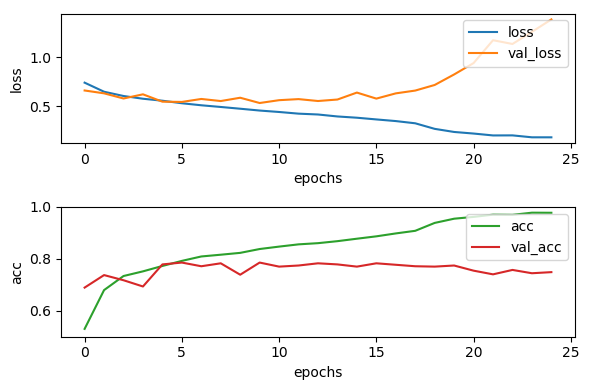

In [36]:
history = h
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()

In [37]:
y_pred = model.predict(ts_set[0]).ravel()

In [38]:
y_test = ts_set[1]
loss = metrics.log_loss(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred > 0.5)
prec = metrics.precision_score(y_test, y_pred > 0.5)
rcll = metrics.recall_score(y_test, y_pred > 0.5)
auc = metrics.roc_auc_score(y_test, y_pred)
print('Test scores:\n * Log-Loss\t{}\n * Accuracy:\t{}\n '
      '* Precision:\t{}\n * Recall:\t{}\n * AUC: \t{}'.format(loss, acc, prec, rcll, auc))

Test scores:
 * Log-Loss	nan
 * Accuracy:	0.762664963814
 * Precision:	0.753700657895
 * Recall:	0.780332056194
 * AUC: 	0.847310549982


In [ ]:
from mbspbs10pc.plotting import *

# Plot non-normalized confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred > 0.5)
plt.figure(dpi=100)
plot_confusion_matrix(cnf_matrix, classes=['METONLY', 'METX'],
                      title='Confusion matrix', cmap=plt.cm.Blues);

**TOP results so far [6341 training / 705 validation / 4698 test]**

Test scores:
 * Log-Loss	0.425300993082
 * Accuracy:	0.810131971052
 * Precision:	0.817983413357
 * Recall:	0.797786292039
 * AUC: 	0.894714579232

In [ ]:
# model.save_weights('model.h5')

In [ ]:
model.load_weights('model.h5')

# Attention viz

In [ ]:
from mbspbs10pc import read_activations
reload(read_activations);

_x_test = [X_test, X_test_t.reshape(len(y_test), maxlen, 1)]
a = read_activations.get_activations(model, _x_test, print_shape_only=True, layer_name='attention_matrix')

In [ ]:
true_pos_idx = np.where(np.logical_and(y_test == 1, y_pred >= 0.5))[0]
true_neg_idx = np.where(np.logical_and(y_test == 0, y_pred < 0.5))[0]
false_pos_idx = np.where(np.logical_and(y_test == 1, y_pred < 0.5))[0]
false_neg_idx = np.where(np.logical_and(y_test == 0, y_pred >= 0.5))[0]

In [ ]:
def get_att(att, idx):
    return np.mean(np.mean(att[0][idx, :, :], axis=0), axis=0)

true_pos_att = get_att(a, true_pos_idx)
true_neg_att = get_att(a, true_neg_idx)
false_pos_att = get_att(a, false_pos_idx)
false_neg_att = get_att(a, false_neg_idx)

In [ ]:
plt.figure(dpi=100)
plt.title('true pos att')
plt.plot(np.arange(445), true_pos_att, 'o');

In [ ]:
plt.figure(dpi=100)
plt.title('true neg att')
plt.plot(np.arange(445), true_neg_att, 'o');

In [ ]:
plt.figure(dpi=100)
plt.title('false pos att')
plt.plot(np.arange(445), false_pos_att, 'o');

In [ ]:
plt.figure(dpi=100)
plt.title('false neg att')
plt.plot(np.arange(445), false_neg_att, 'o');